### pobranie bibliotek

In [1]:
import pandas as pd
import numpy as np
import math
np.random.seed(0)

import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm

import eli5
import re

import matplotlib.pyplot as plt

### ustawienia wyświetlania

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option("max_info_columns", 300)
pd.set_option("max_info_rows", 300)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

### funkcje

In [3]:
def check_log_model(df, feats, model, cv=5, scoring=mean_absolute_error, show_eli5=True):
    df_train = df[ ~df["price_value"].isnull() ].copy()

    X = df_train[feats]
    y = df_train["price_value"]
    y_log = np.log(y)
    
    cv = KFold(n_splits=cv, shuffle=True, random_state=0)
    scores = []
    for train_idx, test_idx in tqdm(cv.split(X)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_log_train, y_test = y_log.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_log_train)
        y_log_pred = model.predict(X_test)
        y_pred = np.exp(y_log_pred)

        
        score = scoring(y_test, y_pred)
        scores.append(score)
        
    result = np.mean(scores), np.std(scores)
    
    if show_eli5:
        model.fit(X, y_log)
        print(result)
        return eli5.show_weights(model, feature_names=feats)

    return result

### import data

In [4]:
df_train = pd.read_hdf("../input/df.train.h5")
df_test = pd.read_hdf("../input/df.test.h5")
print(df_train.shape, df_test.shape)

(80129, 10) (80129, 7)


In [5]:
df_train.sample(5)

,id,price_details,price_value,price_currency,features,seller_name,seller_type,seller_address,breadcrumb,offer_params
8536,8536,Cena Brutto,26 500,PLN,"[ABS, Elektryczne szyby przednie, Poduszka pow...",None,Osoba prywatna,"Pawłów, starachowicki, Świętokrzyskie","[Osobowe, Suzuki, Grand Vitara, Suzuki Grand V...","{'Kolor': 'Srebrny', 'Model pojazdu': 'Grand V..."
27573,27573,"Cena Netto, Faktura VAT",24 389,PLN,"[ABS, Centralny zamek, Elektrycznie ustawiane ...",AAA AUTO - aż 1000 samochodów w ofercie! do 24...,Dealer,"Okulickiego 3B - 05-500 Piaseczno, piaseczyńsk...","[Osobowe, Opel, Corsa, Opel Corsa D (2006-2014)]","{'Bezwypadkowy': 'Tak', 'Liczba miejsc': '5', ..."
4556,4556,Cena Brutto,9 900,PLN,"[ABS, Elektryczne szyby przednie, Poduszka pow...",FHU OLKAR,Dealer,"ul. LEŚNA 19B - 87-148 Łysomice, toruński, Kuj...","[Osobowe, Nissan, Primera, Nissan Primera P12 ...","{'Liczba miejsc': '5', 'Pojemność skokowa': '2..."
34165,34165,Cena Brutto,16 500,PLN,"[ABS, Elektryczne szyby przednie, Poduszka pow...",LUCKY - SALON SAMOCHODÓW UŻYWANYCH Z GWARANCJ...,Dealer,"Konstytucji 117 - 41-906 Bytom, Śląskie (Polska)","[Osobowe, Toyota, Yaris, Toyota Yaris II (2005...","{'Liczba miejsc': '5', 'Kraj pochodzenia': 'Ni..."
26021,26021,"Cena Brutto, Do negocjacji",5 800,PLN,"[ABS, Elektrycznie ustawiane lusterka, Poduszk...",AGIER-CARS,Dealer,"SZEROKA 25 - 95-030 Starowa Góra, łódzki wscho...","[Osobowe, Peugeot, 206]","{'Kolor': 'Srebrny', 'Model pojazdu': '206', '..."


### price

In [6]:
df_train["price_value"] = df_train["price_value"].map(lambda x: x.replace(" ", "").replace(",", ".") if type(x)==str else x).astype(float)
df_train[df_train["price_value"]>100000000]

,id,price_details,price_value,price_currency,features,seller_name,seller_type,seller_address,breadcrumb,offer_params
106447,106447,Cena Brutto,9999999999999.000,PLN,"[ABS, Elektrycznie ustawiane lusterka, Poduszk...",None,Osoba prywatna,"Lubań, lubański, Dolnośląskie","[Osobowe, Honda, Jazz, Honda Jazz IV (2015-)]","{'Pojemność skokowa': '9 999 cm3', 'Model poja..."


ceny powyżej 100mln raczej nie są realne więc usuwany te wiersze

<AxesSubplot:>

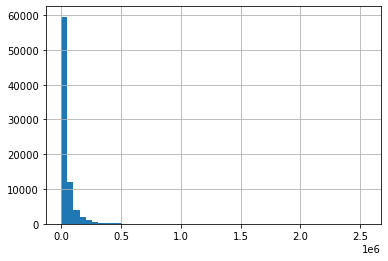

In [7]:
if len(df_train[df_train["price_value"]>100000000]) > 0:
    df_train = df_train.drop(index=106447)
    df_train = df_train.reset_index(drop=True)
    
df_train['price_value'].hist(bins=50)

sprawdzamy rozkład logarytnu z ceny

<AxesSubplot:>

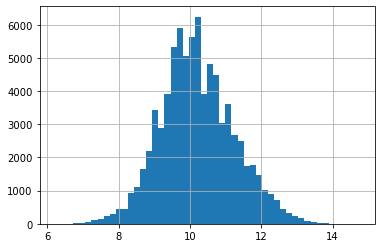

In [8]:
df_train['price_value_log'] = df_train['price_value'].map(lambda x: math.log(x))
df_train['price_value_log'].hist(bins=50)

### połączenie test i train

In [9]:
df = pd.concat([df_train, df_test])
df = df.reset_index(drop=True)

### wyciągnięcie nowych kolumn z kolumny offer_params

In [10]:
offer_params = df["offer_params"].apply(pd.Series)
offer_params = offer_params.fillna(-1)

if "Bezwypadkowy" not in df:
    df = pd.concat([df, offer_params], axis=1)
    
df.sample(5)

,id,price_details,price_value,price_currency,features,seller_name,seller_type,seller_address,breadcrumb,offer_params,price_value_log,Bezwypadkowy,Liczba miejsc,Kraj pochodzenia,Pojemność skokowa,Rodzaj paliwa,Skrzynia biegów,Możliwość finansowania,Pierwszy właściciel,Oferta od,Liczba drzwi,Przebieg,Moc,Metalik,Typ,Kolor,Model pojazdu,Stan,Kategoria,Serwisowany w ASO,Napęd,Leasing,Rok produkcji,Marka pojazdu,Faktura VAT,Pierwsza rejestracja,Zarejestrowany w Polsce,VAT marża,Wersja,VIN,Perłowy,Uszkodzony,Kod Silnika,Filtr cząstek stałych,Emisja CO2,Miesięczna rata,Liczba pozostałych rat,Opłata początkowa,Wartość wykupu,Akryl (niemetalizowany),Tuning,Kierownica po prawej (Anglik),Homologacja ciężarowa,Make,Metallic,Engine capacity,Version,VAT discount,No accident,Mileage,Service record,Door count,Fuel type,Nr of seats,Gearbox,Transmission,Engine power,Model,Color,Country of origin,Body type,Year,Matowy,Acrylic,Financing option,Registered in Poland,Original owner,First registration,Pearl,Zarejestrowany jako zabytek,VAT free,Engine Code,Particle filter,Leasing concession,Damaged,CO2 emissions,Monthly payment value
81259,2278,NaN,nan,NaN,"[ABS, Elektryczne szyby przednie, Poduszka pow...",None,Osoba prywatna,"Tarnów, Małopolskie","[Osobowe, Hyundai, i20, Hyundai i20 II (2014-)]","{'Pojemność skokowa': '1 248 cm3', 'Model poja...",nan,-1,5,-1,1 248 cm3,Benzyna,Manualna,-1,Tak,Osoby prywatnej,5,43 766 km,85 KM,Tak,Auta miejskie,Czarny,i20,Używane,Osobowe,-1,Na przednie koła,-1,2015,Hyundai,-1,-1,-1,-1,II (2014-),-1,-1,Tak,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
19924,39736,Cena Brutto,75900.000,PLN,"[ABS, Elektryczne szyby przednie, Poduszka pow...",Salon Samochodowy Seat Espanola Motor Kielce,Dealer,"1-go Maja 191 - 25-655 Kielce, Świętokrzyskie ...","[Osobowe, Seat, Leon, Seat Leon III (2012-)]","{'Kolor': 'Biały', 'Model pojazdu': 'Leon', 'S...",11.237,Tak,-1,Polska,-1,Benzyna,-1,-1,Tak,Firmy,-1,5 000 km,-1,Tak,Auta miejskie,Biały,Leon,Używane,Osobowe,Tak,-1,-1,2017,Seat,-1,-1,Tak,-1,III (2012-),-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
131391,102180,NaN,nan,NaN,"[ABS, Elektryczne szyby przednie, Poduszka pow...",Auto Komis PERFEKT,Dealer,"Kcyńska 100 - 62-100 Wągrowiec, wągrowiecki, W...","[Osobowe, Citroën, C3, Citroën C3 II (2008-)]","{'Liczba miejsc': '5', 'Pojemność skokowa': '1...",nan,-1,5,-1,1 600 cm3,Diesel,Manualna,Tak,-1,Firmy,5,18 000 km,75 KM,Tak,Auta miejskie,Biały,C3,Używane,Osobowe,-1,Na przednie koła,-1,2015,Citroën,-1,-1,Tak,Tak,II (2008-),-1,Tak,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
150755,141114,NaN,nan,NaN,"[ABS, Elektryczne szyby przednie, Poduszka pow...",None,Osoba prywatna,"Stargard Szczeciński, stargardzki, Zachodniopo...","[Osobowe, Peugeot, 207]","{'Kolor': 'Inny kolor', 'Model pojazdu': '207'...",nan,-1,5,-1,1 600 cm3,Diesel,Manualna,-1,-1,Osoby prywatnej,5,177 145 km,90 KM,Tak,Kombi,Inny kolor,207,Używane,Osobowe,Tak,Na przednie koła,-1,2008,Peugeot,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
119412,78544,NaN,nan,NaN,"[ABS, Elektrycznie ustawiane lusterka, Poduszk...",OPEL ENERGOZAM LUBLIN,Dealer,"Kalinówka 17A - 21-040 Lublin, Lubelskie (Polska)","[Osobowe, Opel, Insignia, Opel Insignia B (201...","{'Pojemność skokowa': '1 498 cm3', 'Model poja...",nan,Tak,5,-1,1 498 cm3,Benzyna,Manualna,-1,-1,Firmy,4,1 km,165 KM,-1,Sedan,Szary,Insignia,Nowe,Osobowe,-1,-1,-1,2017,Opel,Tak,-1,-1,-1,B (2017-),-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


### angielskie cechy

Widzimy, że pewne kolumny z nazwą po polsku i po ongielsku pokrywają się

In [11]:
feat_pairs = [
    ['Bezwypadkowy','No accident'],
    ['Liczba miejsc','Nr of seats'],
    ['Kraj pochodzenia','Country of origin'], 
    ['Pojemność skokowa','Engine capacity'],
    ['Rodzaj paliwa','Fuel type'],
    ['Skrzynia biegów','Gearbox'],
    ['Możliwość finansowania','Financing option'], 
    ['Pierwszy właściciel','Original owner'],
    ['Liczba drzwi','Door count'],
    ['Przebieg','Mileage'],
    ['Moc','Engine power'],
    ['Metalik','Metallic'],
    ['Typ','Body type'],
    ['Kolor','Color'],
    ['Model pojazdu','Model'], 
    ['Serwisowany w ASO','Service record'],
    ['Napęd','Transmission'],
    ['Leasing','Leasing concession'],
    ['Rok produkcji','Year'],
    ['Marka pojazdu','Make'],
    ['Faktura VAT','VAT free'],
    ['Pierwsza rejestracja','First registration'], 
    ['Zarejestrowany w Polsce','Registered in Poland'],
    ['VAT marża','VAT discount'],
    ['Wersja','Version'],
    ['Perłowy','Pearl'],
    ['Uszkodzony','Damaged'], 
    ['Kod Silnika','Engine Code'],
    ['Filtr cząstek stałych','Particle filter'], 
    ['Emisja CO2','CO2 emissions'],
    ['Miesięczna rata','Monthly payment value'],
    ['Akryl (niemetalizowany)','Acrylic']
]

sprawdzamy czy występują wiersze gdzie w obu kolumnach z danej pary są wartości różne od -1

In [12]:
szukane_indexy = []
for row in tqdm(range(len(df))): 
    for feat in feat_pairs:
        if df[feat[0]][row] != -1 and df[feat[1]][row] != -1: 
            szukane_indexy.append(row)
szukane_indexy

100%|████████████████████████████████████████████████████████████████████████| 160257/160257 [00:59<00:00, 2673.56it/s]


[]

nie ma takich wierszy więc możemy połączyć te kolumny

In [13]:
for feat in tqdm(feat_pairs):
    if feat[1] in df:
        df[feat[0]] = df[feat[0]].map(lambda x: '' if x == -1 else x)
        df[feat[1]] = df[feat[1]].map(lambda x: '' if x == -1 else x)
        df[feat[0]] = df[feat[0]] + df[feat[1]]
        df[feat[0]] = df[feat[0]].map(lambda x: -1 if x == '' else x)  
        del df[feat[1]]

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:12<00:00,  2.61it/s]


sprawdzamy model po przetransformowaniu zmiennych object na number za pomocą factorize()

In [14]:
black_list = ['breadcrumb', 'features', 'id', 'offer_params', 'price_details', 'price_currency']
obj_feats = df.select_dtypes(include=[np.object]).columns
obj_feats = [feat for feat in obj_feats if feat not in black_list]

for feat in obj_feats:
    df["{}_cat".format(feat)] = df[feat].factorize()[0]
    
cat_feats = [feat for feat in df.columns if '_cat' in feat]

check_log_model(df, cat_feats, xgb.XGBRegressor(max_depth=5, n_estimators=100, learning_rate=0.3, random_state=0), show_eli5=True)

5it [00:16,  3.40s/it]


(9690.062148875484, 169.6867176323111)


Weight,Feature
0.3390,Faktura VAT_cat
0.0971,Stan_cat
0.0755,Rok produkcji_cat
0.0608,Skrzynia biegów_cat
0.0537,Napęd_cat
0.0504,Serwisowany w ASO_cat
0.0353,Oferta od_cat
0.0308,Uszkodzony_cat
0.0278,Kierownica po prawej (Anglik)_cat
0.0269,Typ_cat


### wyciągamy zmienne licznowe

In [15]:
feats_to_int = ['Liczba miejsc', 'Liczba drzwi', 'Rok produkcji']
df[['Liczba miejsc', 'Liczba drzwi', 'Rok produkcji']].sample(5)

,Liczba miejsc,Liczba drzwi,Rok produkcji
102012,5,5,2012
5440,5,5,2005
147132,-1,-1,2017
4595,5,5,2017
27231,-1,-1,2007


In [16]:
for feat in feats_to_int:
    df["{}_num".format(feat)] = df[feat].map(lambda x: int(x))

num_feats = [feat for feat in df.columns if '_num' in feat]

In [17]:
for feat_name in feats_to_int:
    cat_feats = [feat for feat in cat_feats if feat_name not in feat]
    
feats_to_go = cat_feats + num_feats
check_log_model(df, feats_to_go, xgb.XGBRegressor(max_depth=5, n_estimators=100, learning_rate=0.3, random_state=0), show_eli5=True)

5it [00:17,  3.45s/it]


(9002.778636221432, 213.68403710883877)


Weight,Feature
0.3702,Rok produkcji_num
0.1768,Napęd_cat
0.0478,Skrzynia biegów_cat
0.0448,Serwisowany w ASO_cat
0.0444,Uszkodzony_cat
0.0350,Kierownica po prawej (Anglik)_cat
0.0299,Typ_cat
0.0237,Faktura VAT_cat
0.0195,Stan_cat
0.0194,Bezwypadkowy_cat


kolumna features - najprostszą rzeczą jaką możemy zrobić jest wyciągnięcie liczby elementów listy

In [18]:
df['features'].sample(3)

108962    [ABS, Elektryczne szyby przednie, Poduszka pow...
70042     [ABS, Elektryczne szyby przednie, Poduszka pow...
145911    [ABS, Elektryczne szyby przednie, Poduszka pow...
Name: features, dtype: object

In [19]:
df['features_len'] = df['features'].map(lambda x: len(x))

feats_to_go = [feat for feat in feats_to_go if 'features' not in feat]
feats_to_go = feats_to_go + ['features_len']

check_log_model(df, feats_to_go, xgb.XGBRegressor(max_depth=5, n_estimators=100, learning_rate=0.3, random_state=0), show_eli5=True)

5it [00:17,  3.55s/it]


(9045.613060362171, 169.440700013486)


Weight,Feature
0.4066,Rok produkcji_num
0.1482,Napęd_cat
0.0791,Skrzynia biegów_cat
0.0436,features_len
0.0418,Uszkodzony_cat
0.0363,Kierownica po prawej (Anglik)_cat
0.0335,Faktura VAT_cat
0.0260,Typ_cat
0.0155,Marka pojazdu_cat
0.0153,Liczba miejsc_num


parametry samochodów: Pojemność skokowa, Przebieg, Moc, Emisja CO2

In [20]:
df[["Pojemność skokowa", "Przebieg", "Moc", 'Emisja CO2']].sample(5)

,Pojemność skokowa,Przebieg,Moc,Emisja CO2
21593,1 590 cm3,124 144 km,117 KM,-1
141846,1 298 cm3,178 000 km,87 KM,-1
92581,1 995 cm3,315 000 km,116 KM,-1
75180,1 300 cm3,131 000 km,70 KM,-1
49991,1 685 cm3,183 452 km,115 KM,-1


In [21]:
df["Pojemność skokowa_num"] = df["Pojemność skokowa"].map(lambda x: x.replace(" ", "").replace(",", ".").replace("cm3", "") if type(x)==str else x).astype(int)
df["Przebieg_num"] = df["Przebieg"].map(lambda x: x.replace(" ", "").replace(",", ".").replace("KM", "").replace("km", "") if type(x)==str else x).astype(int)
df["Moc_num"] = df["Moc"].map(lambda x: x.replace(" ", "").replace(",", ".").replace("KM", "").replace("km", "").replace("HP", "") if type(x)==str else x).astype(int)
df['Emisja CO2_num'] = df['Emisja CO2'].map(lambda x: x.replace(" ", "").replace(",", ".").replace("g/km", "") if type(x)==str else x).astype(int)

df[["Pojemność skokowa_num", "Przebieg_num", "Moc_num", 'Emisja CO2_num']].describe()

,Pojemność skokowa_num,Przebieg_num,Moc_num,Emisja CO2_num
count,160257.000,160257.000,160257.000,160257.000
mean,2204.690,144121.565,146.632,7.737
std,16811.127,124999.307,1890.512,2500.069
min,-1.000,-1.000,-1.000,-1.000
25%,1422.000,68000.000,93.000,-1.000
50%,1800.000,154000.000,122.000,-1.000
75%,2000.000,205000.000,156.000,-1.000
max,3000218.000,14600690.000,543848.000,1000000.000


In [22]:
feats_to_go = [feat for feat in feats_to_go if 'Emisja CO2' not in feat]
feats_to_go = feats_to_go + ['Emisja CO2_num']

Text(0.5, 1.0, 'Moc_num')

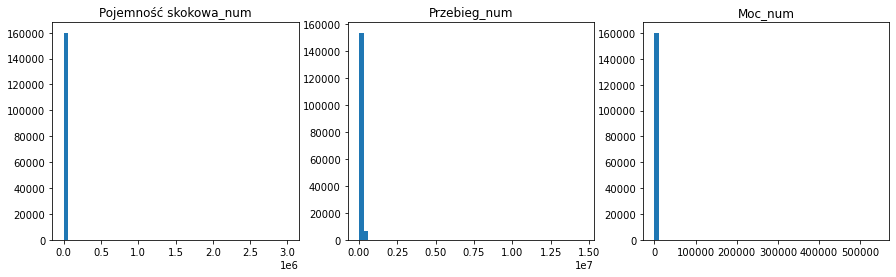

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(15,4))
axs[0].hist(df['Pojemność skokowa_num'], bins=50)
axs[0].set_title("Pojemność skokowa_num")
axs[1].hist(df['Przebieg_num'], bins=50)
axs[1].set_title("Przebieg_num")
axs[2].hist(df['Moc_num'], bins=50)
axs[2].set_title("Moc_num")

In [24]:
for feat_name in ["Pojemność skokowa", "Przebieg", "Moc"]:
    feats_to_go = [feat for feat in feats_to_go if feat_name not in feat]
    
parametry = ["Pojemność skokowa_num", "Przebieg_num", "Moc_num"]    
    
temp_feats = feats_to_go + parametry
check_log_model(df, temp_feats, xgb.XGBRegressor(max_depth=5, n_estimators=100, learning_rate=0.3, random_state=0), show_eli5=True)

5it [00:23,  4.74s/it]


(7810.798807427467, 151.8898526679013)


Weight,Feature
0.3801,Rok produkcji_num
0.1214,Moc_num
0.0864,Napęd_cat
0.0708,Skrzynia biegów_cat
0.0423,features_len
0.0337,Uszkodzony_cat
0.0310,Kierownica po prawej (Anglik)_cat
0.0218,Pojemność skokowa_num
0.0212,Faktura VAT_cat
0.0211,Przebieg_num


zmiana na logarytmy

Text(0.5, 1.0, 'Moc_num_log')

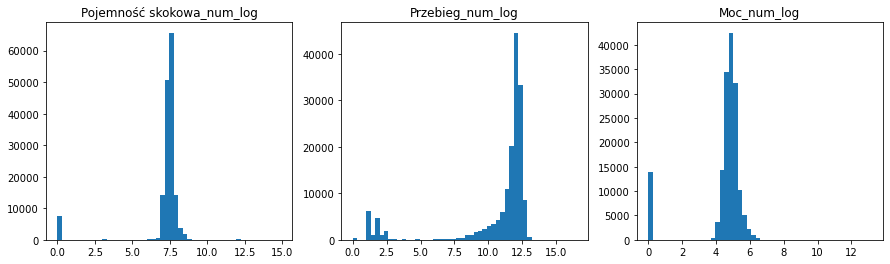

In [25]:
for feat in parametry:
    df["{}_log".format(feat)] = df[feat].map(lambda x: math.log(x + 2))

fig, axs = plt.subplots(1, 3, figsize=(15,4))
axs[0].hist(df['Pojemność skokowa_num_log'], bins=50)
axs[0].set_title("Pojemność skokowa_num_log")
axs[1].hist(df['Przebieg_num_log'], bins=50)
axs[1].set_title("Przebieg_num_log")
axs[2].hist(df['Moc_num_log'], bins=50)
axs[2].set_title("Moc_num_log")

In [26]:
parametry_log = ["Pojemność skokowa_num_log", "Przebieg_num_log", "Moc_num_log"]
temp_feats = feats_to_go + parametry_log
check_log_model(df, temp_feats, xgb.XGBRegressor(max_depth=5, n_estimators=100, learning_rate=0.3, random_state=0), show_eli5=True)

5it [00:27,  5.47s/it]


(7810.623088289202, 151.60498858538227)


Weight,Feature
0.3801,Rok produkcji_num
0.1214,Moc_num_log
0.0864,Napęd_cat
0.0708,Skrzynia biegów_cat
0.0423,features_len
0.0337,Uszkodzony_cat
0.0310,Kierownica po prawej (Anglik)_cat
0.0218,Pojemność skokowa_num_log
0.0212,Faktura VAT_cat
0.0211,Przebieg_num_log


odrzucenie wartości odstających

In [27]:
def reset_outlires(df, feat, prc=99):
    cut_value = np.percentile(df[feat], prc)
    
    return df[feat].map(lambda x: x if x < cut_value else -1)

Text(0.5, 1.0, 'Moc_num_99')

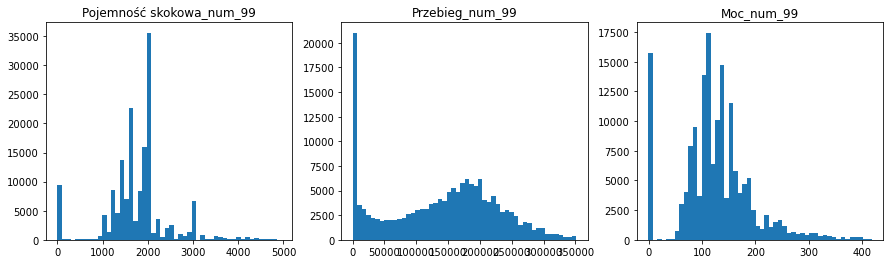

In [28]:
df["Pojemność skokowa_num_99"] = reset_outlires(df, "Pojemność skokowa_num")
df["Moc_num_99"] = reset_outlires(df, "Moc_num")
df["Przebieg_num_99"] = reset_outlires(df, "Przebieg_num")

fig, axs = plt.subplots(1, 3, figsize=(15,4))
axs[0].hist(df['Pojemność skokowa_num_99'], bins=50)
axs[0].set_title("Pojemność skokowa_num_99")
axs[1].hist(df['Przebieg_num_99'], bins=50)
axs[1].set_title("Przebieg_num_99")
axs[2].hist(df['Moc_num_99'], bins=50)
axs[2].set_title("Moc_num_99")

In [29]:
parametry_99 = ["Pojemność skokowa_num_99", "Przebieg_num_99", "Moc_num_99"]
temp_feats = feats_to_go + parametry_99
check_log_model(df, temp_feats, xgb.XGBRegressor(max_depth=5, n_estimators=100, learning_rate=0.3, random_state=0), show_eli5=True)

5it [00:28,  5.73s/it]


(8071.57607826536, 119.96568220906948)


Weight,Feature
0.3601,Rok produkcji_num
0.1860,Napęd_cat
0.1098,Skrzynia biegów_cat
0.0483,Moc_num_99
0.0433,features_len
0.0342,Uszkodzony_cat
0.0260,Kierownica po prawej (Anglik)_cat
0.0200,Bezwypadkowy_cat
0.0180,Typ_cat
0.0173,Faktura VAT_cat


logarytm z cech bez wartości odstających

Text(0.5, 1.0, 'Moc_num_99_log')

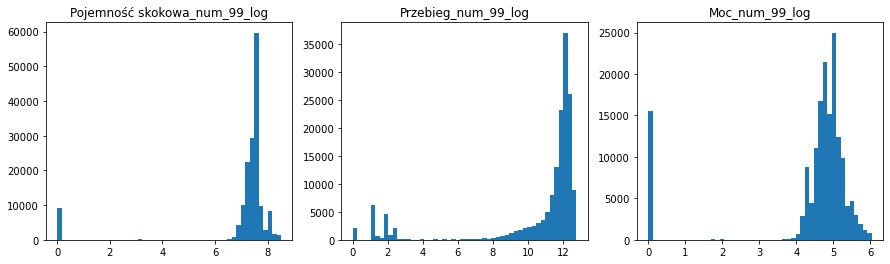

In [30]:
feats_to_log = ["Pojemność skokowa_num_99", "Przebieg_num_99", "Moc_num_99"]
for feat in feats_to_log:
    df["{}_log".format(feat)] = df[feat].map(lambda x: math.log(x + 2))

fig, axs = plt.subplots(1, 3, figsize=(15,4))
axs[0].hist(df['Pojemność skokowa_num_99_log'], bins=50)
axs[0].set_title("Pojemność skokowa_num_99_log")
axs[1].hist(df['Przebieg_num_99_log'], bins=50)
axs[1].set_title("Przebieg_num_99_log")
axs[2].hist(df['Moc_num_99_log'], bins=50)
axs[2].set_title("Moc_num_99_log")

In [31]:
parametry_99_log = ["Pojemność skokowa_num_99_log", "Przebieg_num_99_log", "Moc_num_99_log"]
temp_feats = feats_to_go + parametry_99_log
check_log_model(df, temp_feats, xgb.XGBRegressor(max_depth=5, n_estimators=100, learning_rate=0.3, random_state=0), show_eli5=True)

5it [00:27,  5.60s/it]


(8071.258679552065, 119.61227053594865)


Weight,Feature
0.3601,Rok produkcji_num
0.1860,Napęd_cat
0.1098,Skrzynia biegów_cat
0.0483,Moc_num_99_log
0.0433,features_len
0.0342,Uszkodzony_cat
0.0260,Kierownica po prawej (Anglik)_cat
0.0200,Bezwypadkowy_cat
0.0180,Typ_cat
0.0173,Faktura VAT_cat


najlepiej wypadają logarytmy z cech i te rozpatrujemy w dalszych działaniach

In [32]:
feats_to_go = feats_to_go + parametry_log

dużo zmiennych można przekształcić na bool

In [33]:
feats_to_bool = [
    'Bezwypadkowy',
    'Możliwość finansowania',
    'Pierwszy właściciel',
    'Metalik',
    'Serwisowany w ASO',
    'Leasing',
    'Faktura VAT',
    'Zarejestrowany w Polsce',
    'VAT marża',
    'Perłowy',
    'Uszkodzony',
    'Filtr cząstek stałych',
    'Akryl (niemetalizowany)',
    'Tuning',
    'Kierownica po prawej (Anglik)',
    'Homologacja ciężarowa',
    'Matowy',
    'Zarejestrowany jako zabytek'
]

In [34]:
for feat in feats_to_bool:
    print(df[feat].value_counts())

Tak    100707
-1      59550
Name: Bezwypadkowy, dtype: int64
-1     106509
Tak     53748
Name: Możliwość finansowania, dtype: int64
-1     89288
Tak    70969
Name: Pierwszy właściciel, dtype: int64
Tak         109414
-1           50815
metallic        28
Name: Metalik, dtype: int64
-1     81257
Tak    79000
Name: Serwisowany w ASO, dtype: int64
-1     142909
Tak     17348
Name: Leasing, dtype: int64
-1     120434
Tak     39823
Name: Faktura VAT, dtype: int64
-1     86152
Tak    74105
Name: Zarejestrowany w Polsce, dtype: int64
-1     105678
Tak     54579
Name: VAT marża, dtype: int64
-1     142816
Tak     17441
Name: Perłowy, dtype: int64
-1     153962
Tak      6295
Name: Uszkodzony, dtype: int64
-1     150860
Tak      9397
Name: Filtr cząstek stałych, dtype: int64
-1         154120
Tak          6131
acrylic         6
Name: Akryl (niemetalizowany), dtype: int64
-1     159385
Tak       872
Name: Tuning, dtype: int64
-1     159095
Tak      1162
Name: Kierownica po prawej (Anglik), dtype:

In [35]:
for feat in feats_to_bool:
    df["{}_bool".format(feat)] = df[feat].map(lambda x: False if x == -1 or x == False else True)
    
bool_feats = [feat for feat in df.columns if '_bool' in feat]

for feat_name in feats_to_bool:
    feats_to_go = [feat for feat in feats_to_go if feat_name not in feat]
    
temp_feats = feats_to_go + bool_feats
check_log_model(df, temp_feats, xgb.XGBRegressor(max_depth=5, n_estimators=100, learning_rate=0.3, random_state=0), show_eli5=True)

5it [00:25,  5.12s/it]


(7810.770670868427, 151.30296418242986)


Weight,Feature
0.3741,Rok produkcji_num
0.1128,Moc_num_log
0.0809,Napęd_cat
0.0670,Skrzynia biegów_cat
0.0412,features_len
0.0410,Serwisowany w ASO_bool
0.0335,Uszkodzony_bool
0.0290,Kierownica po prawej (Anglik)_bool
0.0247,Bezwypadkowy_bool
0.0216,Pojemność skokowa_num_log


także cechy 'Oferta od', 'Stan' można przekształcić na bool

In [36]:
for feat in ['Oferta od', 'Stan']: print(df[feat].value_counts())

Firmy              97094
Osoby prywatnej    63163
Name: Oferta od, dtype: int64
Używane    145961
Nowe        14296
Name: Stan, dtype: int64


In [37]:
df['Oferta od firmy'] = df['Oferta od'].map(lambda x: True if x == 'Firmy' or x == True else False)
df['Uzywany'] = df['Stan'].map(lambda x: True if x == 'Używane' or x == True else False)

for feat_name in ['Oferta od', 'Stan']:
    feats_to_go = [feat for feat in feats_to_go if feat_name not in feat]
    
temp_feats = feats_to_go + bool_feats + ['Oferta od firmy', 'Uzywany']
check_log_model(df, temp_feats, xgb.XGBRegressor(max_depth=5, n_estimators=100, learning_rate=0.3, random_state=0), show_eli5=True)

5it [00:25,  5.13s/it]


(7810.683025401687, 151.30577485113648)


Weight,Feature
0.3741,Rok produkcji_num
0.1128,Moc_num_log
0.0809,Napęd_cat
0.0670,Skrzynia biegów_cat
0.0412,features_len
0.0410,Serwisowany w ASO_bool
0.0335,Uszkodzony_bool
0.0290,Kierownica po prawej (Anglik)_bool
0.0247,Bezwypadkowy_bool
0.0216,Pojemność skokowa_num_log


In [38]:
feats_to_go = feats_to_go + bool_feats + ['Oferta od firmy', 'Uzywany']

wyciągamy wartości liczbowe z kolumn 'Miesięczna rata', 'Liczba pozostałych rat', 'Opłata początkowa', 'Wartość wykupu'

In [39]:
for feat in ['Miesięczna rata', 'Liczba pozostałych rat', 'Opłata początkowa', 'Wartość wykupu']: 
    print(df[feat].value_counts().head(5))

-1         159529
400 PLN        28
600 PLN        21
500 PLN        15
700 PLN        13
Name: Miesięczna rata, dtype: int64
-1    159814
36        81
48        30
60        24
47        21
Name: Liczba pozostałych rat, dtype: int64
-1            159844
1 PLN             31
15 000 PLN        13
20 000 PLN        12
5 000 PLN          8
Name: Opłata początkowa, dtype: int64
-1            159849
1 PLN             15
1 000 PLN          6
21 000 PLN         3
50 000 PLN         3
Name: Wartość wykupu, dtype: int64


In [40]:
for feat in ['Miesięczna rata', 'Liczba pozostałych rat', 'Opłata początkowa', 'Wartość wykupu']: 
    df["{}_payment".format(feat)] = df[feat].map(lambda x: str(x).replace(' ','').replace(',','.').split('PLN')[0] if x != -1 else -1).astype(float)

#df['zostalo_do_zaplaty_payment'] = df['Miesięczna rata_payment'] * df['Liczba pozostałych rat_payment'] + df['Opłata początkowa_payment']

for feat_name in ['Miesięczna rata', 'Liczba pozostałych rat', 'Opłata początkowa', 'Wartość wykupu']:
    feats_to_go = [feat for feat in feats_to_go if feat_name not in feat]

feats_payment = [feat for feat in df.columns if '_payment' in feat]

temp_feats = feats_to_go + feats_payment
check_log_model(df, temp_feats, xgb.XGBRegressor(max_depth=5, n_estimators=100, learning_rate=0.3, random_state=0), show_eli5=True)

5it [00:25,  5.12s/it]


(7891.647567263254, 125.96312646636103)


Weight,Feature
0.3960,Rok produkcji_num
0.1183,Moc_num_log
0.0800,Skrzynia biegów_cat
0.0707,Napęd_cat
0.0426,features_len
0.0377,Uszkodzony_bool
0.0280,Kierownica po prawej (Anglik)_bool
0.0232,Faktura VAT_bool
0.0208,Bezwypadkowy_bool
0.0206,Przebieg_num_log


In [41]:
#feats_to_go = feats_to_go + feats_payment

kolumna "Pierwsza rejestracja"

In [42]:
df["Pierwsza rejestracja"].value_counts().head(5)

-1                 102019
1 styczeń 2007         83
1 styczeń 2014         83
1 styczeń 2016         82
1 czerwiec 2007        82
Name: Pierwsza rejestracja, dtype: int64

In [43]:
df["first_regestration_year"] = df["Pierwsza rejestracja"].map(lambda x: int(str(x).split(' ')[-1]))

feats_to_go = [feat for feat in feats_to_go if "Pierwsza rejestracja" not in feat]
    
temp_feats = feats_to_go + ["first_regestration_year"]
check_log_model(df, temp_feats, xgb.XGBRegressor(max_depth=5, n_estimators=100, learning_rate=0.3, random_state=0), show_eli5=True)

5it [00:24,  4.85s/it]


(7756.363589792636, 166.5342324844847)


Weight,Feature
0.4097,Rok produkcji_num
0.1093,Moc_num_log
0.0746,Napęd_cat
0.0732,Skrzynia biegów_cat
0.0408,Uszkodzony_bool
0.0367,features_len
0.0310,Kierownica po prawej (Anglik)_bool
0.0216,Bezwypadkowy_bool
0.0208,Faktura VAT_bool
0.0208,Przebieg_num_log


In [44]:
feats_to_go = feats_to_go + ["first_regestration_year"]

dzielimy wartości w kolumnie kod silnika

In [45]:
df["Kod Silnika"].unique()

array([-1, 'GLE 350', 'E 220', '523', '525', 'ML 320', '520', '320',
       'C 180', '530', 'GLC 250', 'C 220', 'CL 500', 'E 350', '318',
       'C 200', 'S 320', '116', '120', 'S 350', 'A 180', 'GLC 220', '118',
       '745', 'C 270', 'A 170', 'B 180', '325', '328', '430', '528',
       'A 160', 'SL 55 AMG', '750', 'E 320', '650', 'CLA 220', 'E 250',
       '330', 'E 230', '730', 'CLA 180', 'GLA 220', 'A 200', 'B 200',
       '535', '630', 'G 300', 'A 140', 'E 200', '540', 'S 63 AMG', '640',
       'CLA 45 AMG', '335', 'S 500', 'E 500', 'GLA 200', 'CLK 320',
       'CLS 63 AMG', 'G 500', 'A45 AMG', 'GLA 180', 'CLS 250', 'A 190',
       'E 63 AMG', 'R 350', '740', '420', '760', 'CLK 200', 'A 250',
       'C 300', 'C 230', 'CLK 270', 'B 150', 'S 65 AMG', 'G 63 AMG',
       'CLA 250', 'F01', 'S 400', 'CLS 500', 'CLA 200', '316', 'ML 350',
       'CLS 350', 'GL 420', 'E 290', 'C 320', '123', 'C 160', 'SL 500',
       'E 280', '518', 'ML 500', 'C 63 AMG', 'B 160', 'S 280',
       'SL 63 AM

In [46]:
df['kod_silnika_symbol'] = df['Kod Silnika'].map(lambda x: str(x).split(' ')[0] if len(str(x).split(' ')) > 1 else -1)
df["kod_silnika_symbol_cat"] = df['kod_silnika_symbol'].factorize()[0]

df['kod_silnika_numer'] = df['Kod Silnika'].map(lambda x: re.findall(r'[0-9]+', str(x).replace(' ', '')))
df['kod_silnika_numer'] = df['kod_silnika_numer'].map(lambda x: x[0]).astype(int)

df['kod_silnika_AMG'] = df['Kod Silnika'].map(lambda x: True if 'AMG' in str(x) else False)

In [47]:
temp_feats = feats_to_go + ['kod_silnika_symbol_cat']
check_log_model(df, temp_feats, xgb.XGBRegressor(max_depth=5, n_estimators=100, learning_rate=0.3, random_state=0), show_eli5=False)

5it [00:25,  5.01s/it]


(7783.5669454880535, 140.20773162790098)

In [48]:
temp_feats = feats_to_go + ['kod_silnika_numer']
check_log_model(df, temp_feats, xgb.XGBRegressor(max_depth=5, n_estimators=100, learning_rate=0.3, random_state=0), show_eli5=False)

5it [00:24,  4.93s/it]


(7761.729505227774, 132.55104802102292)

In [49]:
temp_feats = feats_to_go + ['kod_silnika_AMG']
check_log_model(df, temp_feats, xgb.XGBRegressor(max_depth=5, n_estimators=100, learning_rate=0.3, random_state=0), show_eli5=False)

5it [00:24,  4.94s/it]


(7781.8939320816835, 129.0918309660541)

In [50]:
feats_to_go = [feat for feat in feats_to_go if "Kod Silnika" not in feat]
feats_to_go = feats_to_go + ['kod_silnika_symbol_cat', 'kod_silnika_numer', 'kod_silnika_AMG']

wyciągamy lata od - do z kolumny wersja

In [51]:
df["Wersja"].value_counts().head(10)

-1                  35955
II (2012-)           2330
H (2004-2014)        2131
II (2008-)           1858
II (2003 - 2009)     1795
A (2008-2017)        1741
E90 (2005-2012)      1576
II (2010-)           1573
J (2009-2015)        1529
E46 (1998-2007)      1492
Name: Wersja, dtype: int64

In [52]:
df["version_years"] = df["Wersja"].map(lambda x: re.findall(r'(\d+)-(\d+)?', str(x)) )

df["version_year_from"] = df["version_years"].map(lambda x: x[0][0] if x else -1).astype(int)
df["version_year_to"] = df["version_years"].map(lambda x: x[0][1] if x and x[0][1] != "" else -1).astype(int)
if 'version_years' in df: del df['version_years']
    
feats_to_go = [feat for feat in feats_to_go if "Wersja" not in feat]
    
temp_feats = feats_to_go + ['version_year_from', 'version_year_to']
check_log_model(df, temp_feats, xgb.XGBRegressor(max_depth=5, n_estimators=100, learning_rate=0.3, random_state=0), show_eli5=True)

5it [00:25,  5.06s/it]


(7681.499731408474, 143.76780335862327)


Weight,Feature
0.4011,Rok produkcji_num
0.1045,Moc_num_log
0.0843,Skrzynia biegów_cat
0.0719,Napęd_cat
0.0382,Uszkodzony_bool
0.0357,features_len
0.0255,Kierownica po prawej (Anglik)_bool
0.0236,Bezwypadkowy_bool
0.0232,Faktura VAT_bool
0.0199,Przebieg_num_log


In [53]:
feats_to_go = feats_to_go + ['version_year_from', 'version_year_to']

wyciągamy nazwę województwa sprzedawcy z kolumny seller_address

In [54]:
df['seller_address'].value_counts().head(10)

Radom, Mazowieckie                                                       994
Lublin, Lubelskie                                                        790
Kielce, Świętokrzyskie                                                   761
Ostrów Mazowiecka, ostrowski, Mazowieckie                                531
Bydgoszcz, Kujawsko-pomorskie                                            513
Ostrów Wielkopolski, ostrowski, Wielkopolskie                            497
Okulickiego 3B - 05-500 Piaseczno, piaseczyński, Mazowieckie (Polska)    471
Wrocław, Dolnośląskie, Krzyki                                            439
Płock, Mazowieckie                                                       429
Rzeszów, Podkarpackie                                                    426
Name: seller_address, dtype: int64

In [55]:
wojewodztwa = [
    'Śląskie',
    'Wielkopolskie',
    'Pomorskie',
    'Dolnośląskie',
    'Mazowieckie',
    'Łódzkie',
    'Kujawsko-pomorskie',
    'Lubuskie',
    'Lubelskie',
    'Małopolskie',
    'Opolskie',
    'Podkarpackie',
    'Podlaskie',
    'Świętokrzyskie',
    'Warmińsko-mazurskie',
    'Zachodniopomorskie'  
]

df['wojewodztwo'] = ''
for woj in wojewodztwa:    
    df[woj] = df['seller_address'].map(lambda x: woj if woj in str(x) else '')
    df['wojewodztwo'] = df['wojewodztwo'] + df[woj]
    del df[woj]
df['wojewodztwo'] = df['wojewodztwo'].map(lambda x: -1 if x == '' else x)

df['wojewodztwo'].value_counts()

Mazowieckie                     22507
Wielkopolskie                   21376
-1                              20728
Śląskie                         16054
Małopolskie                     12010
Dolnośląskie                    10213
Łódzkie                          8194
Pomorskie                        7435
Kujawsko-pomorskie               6856
Lubelskie                        6801
Podkarpackie                     5314
Świętokrzyskie                   5017
Zachodniopomorskie               4706
Warmińsko-mazurskie              3915
Lubuskie                         3903
Opolskie                         2795
Podlaskie                        2162
ŚląskieDolnośląskie               184
MazowieckiePodlaskie               32
PomorskieKujawsko-pomorskie        28
PomorskieZachodniopomorskie        22
LubelskieWarmińsko-mazurskie        4
ŚląskieOpolskie                     1
Name: wojewodztwo, dtype: int64

In [56]:
df["wojewodztwo_cat"] = df['wojewodztwo'].factorize()[0]

temp_feats = feats_to_go + ['wojewodztwo_cat']
check_log_model(df, temp_feats, xgb.XGBRegressor(max_depth=5, n_estimators=100, learning_rate=0.3, random_state=0), show_eli5=True)

5it [00:25,  5.15s/it]


(7700.038069547435, 203.32216690911997)


Weight,Feature
0.3979,Rok produkcji_num
0.1055,Moc_num_log
0.0796,Skrzynia biegów_cat
0.0762,Napęd_cat
0.0406,Uszkodzony_bool
0.0392,features_len
0.0263,Kierownica po prawej (Anglik)_bool
0.0221,Bezwypadkowy_bool
0.0216,Przebieg_num_log
0.0182,Pojemność skokowa_num_log


In [57]:
feats_to_go = feats_to_go + ['wojewodztwo_cat']

to samo robimy z nazwą miejscowości

In [58]:
duze_miasta = [
    'Poznań',
    'Warszawa',
    'Kraków',
    'Gdańsk',
    'Szczecin',
    'Wrocław',
    'Opole',
    'Częstochowa',
    'Rzeszów',
    'Łódź',
    'Katowice',
    'Gliwice',
    'Bydgoszcz',
    'Lublin',
    'Białystok'    
]

for miasto in duze_miasta:
    df['duze_miasta'] = df['seller_address'].map(lambda x: True if miasto in x or x == True else False)
    
df['duze_miasta'].value_counts()

False    158496
True       1761
Name: duze_miasta, dtype: int64

In [59]:
df["duze_miasta_cat"] = df['duze_miasta'].factorize()[0]

temp_feats = feats_to_go + ['duze_miasta_cat']
check_log_model(df, temp_feats, xgb.XGBRegressor(max_depth=5, n_estimators=100, learning_rate=0.3, random_state=0), show_eli5=True)

5it [00:26,  5.21s/it]


(7673.778625054593, 208.57842594204487)


Weight,Feature
0.3940,Rok produkcji_num
0.1084,Moc_num_log
0.0780,Skrzynia biegów_cat
0.0747,Napęd_cat
0.0415,Uszkodzony_bool
0.0367,features_len
0.0269,Kierownica po prawej (Anglik)_bool
0.0238,Bezwypadkowy_bool
0.0223,Przebieg_num_log
0.0185,Pojemność skokowa_num_log


In [60]:
#feats_to_go = feats_to_go + ['duze_miasta']

szukamy prawdopodobnych handlarzy aut używanych w kolumnie seller_name

In [61]:
df['seller_name'].value_counts().head(10)

AAA AUTO - aż 1000 samochodów w ofercie! do 24 m-cy gwarancji - CarLife! aż 80% pojazdów krajowych!    954
Master1                                                                                                495
AUTO-HANDEL                                                                                            432
Auto Handel                                                                                            302
CARSERWIS                                                                                              290
Bawaria Motors Warszawa - Dealer BMW - MINI - BMW M - BMW i                                            262
Polska                                                                                                 260
Grupa KROTOSKI-CICHY Łódź                                                                              255
AUTO - KOMIS "LIFT" Strzegom CZYNNY CODZIENNIE Samochody z Gwarancja                                   222
Super Auto Sp. J. B. Chojnacki, K. Ma

In [62]:
df['skup'] = df['seller_name'].map(lambda x: True if 
                                   'skup' in str(x).lower() or 
                                   'handel' in str(x).lower() or 
                                   'używane' in str(x).lower() or 
                                   'używanych' in str(x).lower() or 
                                   'komis' in str(x).lower() else False)

df['skup'].value_counts()

False    136983
True      23274
Name: skup, dtype: int64

In [63]:
temp_feats = feats_to_go + ['skup']
check_log_model(df, temp_feats, xgb.XGBRegressor(max_depth=5, n_estimators=100, learning_rate=0.3, random_state=0), show_eli5=True)

5it [00:25,  5.20s/it]


(7678.932551029303, 175.3300254631393)


Weight,Feature
0.3963,Rok produkcji_num
0.1045,Moc_num_log
0.0784,Skrzynia biegów_cat
0.0766,Napęd_cat
0.0400,Uszkodzony_bool
0.0388,features_len
0.0254,Kierownica po prawej (Anglik)_bool
0.0235,Bezwypadkowy_bool
0.0214,Przebieg_num_log
0.0187,Faktura VAT_bool


In [64]:
feats_to_go = feats_to_go + ['skup']

po sprawdzeniu w jakich przypadkach model myli się najbardziej dochodzimy do wniosku, że są to drogie samochody. tworzymy więc taką cechę oraz najczęściej występujące modele

In [65]:
df['pelna_nazwa'] = df['Marka pojazdu'] + ' ' + df['Model pojazdu']

In [66]:
drogie_marki = [
#    'Mercedes-Benz',
    'Porsche',
    'Lexus',
    'Jaguar',
    'Aston Martin',
    'Maserati',
    'Ferrari',
    'Lincoln',
    'Bentley',
    'Tesla',
    'Rolls-Royce',
    'Lamborghini',    
]

df['droga_marka'] = df['Marka pojazdu'].map(lambda x: True if x in drogie_marki else False)

temp_feats = feats_to_go + ['droga_marka']
check_log_model(df, temp_feats, xgb.XGBRegressor(max_depth=5, n_estimators=100, learning_rate=0.3, random_state=0), show_eli5=True)

5it [00:26,  5.29s/it]


(7565.974266816818, 106.77967651694094)


Weight,Feature
0.3867,Rok produkcji_num
0.1060,Moc_num_log
0.0779,Skrzynia biegów_cat
0.0710,Napęd_cat
0.0399,features_len
0.0373,Uszkodzony_bool
0.0251,Kierownica po prawej (Anglik)_bool
0.0228,Faktura VAT_bool
0.0218,Przebieg_num_log
0.0185,Pojemność skokowa_num_log


In [67]:
df['Mercedes-Benz Klasa S'] = df['pelna_nazwa'].map(lambda x: True if x == 'Mercedes-Benz Klasa S' else False)
df['BMW Seria 7'] = df['pelna_nazwa'].map(lambda x: True if x == 'BMW Seria 7' else False)
df['Lamborghini Aventador'] = df['pelna_nazwa'].map(lambda x: True if x == 'Lamborghini Aventador' else False)

temp_feats = feats_to_go + ['droga_marka', 'Mercedes-Benz Klasa S', 'BMW Seria 7', 'Lamborghini Aventador']
check_log_model(df, temp_feats, xgb.XGBRegressor(max_depth=5, n_estimators=100, learning_rate=0.3, random_state=0), show_eli5=True)

5it [00:27,  5.54s/it]


(7603.515161909796, 167.9500189122601)


Weight,Feature
0.3962,Rok produkcji_num
0.1070,Moc_num_log
0.0738,Skrzynia biegów_cat
0.0702,Napęd_cat
0.0363,Uszkodzony_bool
0.0361,features_len
0.0251,Kierownica po prawej (Anglik)_bool
0.0216,Przebieg_num_log
0.0203,Bezwypadkowy_bool
0.0196,Faktura VAT_bool


In [68]:
feats_to_go = feats_to_go + ['droga_marka', 'Mercedes-Benz Klasa S', 'BMW Seria 7', 'Lamborghini Aventador']

sprawdzamy czy da się 'zgadnąć' rodzaj napędu i skrzyni biegów po innych ofertach tego samego modelu. wykresy przedstawiają ile procent ma najpopulerniejszy napęd i skrzynia biegów dla danego modelu (dla wartości brakujących)

100%|█████████████████████████████████████████████████████████████████████████| 160257/160257 [09:26<00:00, 282.92it/s]


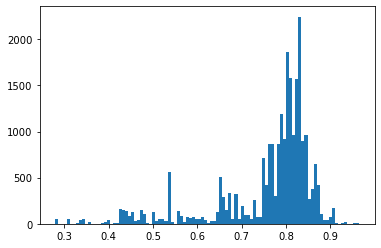

In [69]:
lista = []
for row in tqdm(range(len(df))):
    if df['Napęd'][row] == -1:
        df_temp = df[df['pelna_nazwa'] == df['pelna_nazwa'][row]]
        temp = df_temp['Napęd'].value_counts(normalize = True).head(1)
        if str(dict(temp).keys()).split('[')[1].split(']')[0] != '-1': lista.append(temp[0])
            
plt.hist(np.array(lista) , bins = 100) 
plt.show()

In [70]:
df['Napęd_uzupelnienie'] = -1
for row in tqdm(range(len(df))):
    if df['Napęd'][row] == -1:
        df_temp = df[df['pelna_nazwa'] == df['pelna_nazwa'][row]]
        temp_num = df_temp['Napęd'].value_counts(normalize = True).head(1)
        temp = str(dict(temp_num).keys())
        if float(temp_num) > 0.8:
            df['Napęd_uzupelnienie'][row] = temp.split('[')[1].split(']')[0].replace('\'', '')
        
print(df['Napęd'].value_counts())
print(df['Napęd_uzupelnienie'].value_counts())

  0%|                                                                                       | 0/160257 [00:00<?, ?it/s]<ipython-input-70-1e1d39006965>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Napęd_uzupelnienie'][row] = temp.split('[')[1].split(']')[0].replace('\'', '')
C:\Users\adam\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
100%|█████████████████████████████████████████████████████████████████████████| 160257/160257 [09:40<00:00, 275.93it/s]

Na przednie koła                 99487
-1                               24354
Na tylne koła                    12966
4x4 (stały)                      10665
4x4 (dołączany automatycznie)    10366
4x4 (dołączany ręcznie)           2419
Name: Napęd, dtype: int64
-1                               147663
Na przednie koła                  12309
Na tylne koła                       175
-1                                   82
4x4 (dołączany ręcznie)              19
4x4 (stały)                           8
4x4 (dołączany automatycznie)         1
Name: Napęd_uzupelnienie, dtype: int64


In [71]:
df['Napęd'] = df['Napęd'].map(lambda x: '' if x == -1 else x)
df['Napęd_uzupelnienie'] = df['Napęd_uzupelnienie'].map(lambda x: '' if x == -1 else x)

df['Napęd_uzupelnienie'] = df['Napęd_uzupelnienie'] + df['Napęd']

df['Napęd'] = df['Napęd'].map(lambda x: -1 if x == '' else x)
df['Napęd_uzupelnienie'] = df['Napęd_uzupelnienie'].map(lambda x: -1 if x == '' else x)

df['Napęd_uzupelnienie_cat'] = df['Napęd_uzupelnienie'].factorize()[0]

feats_to_go = [feat for feat in feats_to_go if 'Napęd' not in feat]
    
temp_feats = feats_to_go + ['Napęd_uzupelnienie_cat']
check_log_model(df, temp_feats, xgb.XGBRegressor(max_depth=5, n_estimators=100, learning_rate=0.3, random_state=0), show_eli5=True)

5it [00:19,  3.99s/it]


(7518.713909165954, 208.33053363367807)


Weight,Feature
0.3889,Rok produkcji_num
0.1019,Moc_num_log
0.0817,Napęd_uzupelnienie_cat
0.0571,Skrzynia biegów_cat
0.0420,Uszkodzony_bool
0.0358,features_len
0.0272,Kierownica po prawej (Anglik)_bool
0.0213,Pojemność skokowa_num_log
0.0197,Przebieg_num_log
0.0195,Bezwypadkowy_bool


In [72]:
feats_to_go = feats_to_go + ['Napęd_uzupelnienie_cat']
#feats_to_go = feats_to_go + ['Napęd_cat']

100%|█████████████████████████████████████████████████████████████████████████| 160257/160257 [03:16<00:00, 817.36it/s]


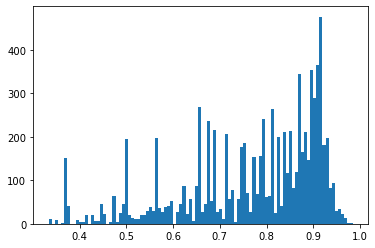

In [73]:
lista = []
for row in tqdm(range(len(df))):
    if df['Skrzynia biegów'][row] == -1:
        df_temp = df[df['pelna_nazwa'] == df['pelna_nazwa'][row]]
        temp = df_temp['Skrzynia biegów'].value_counts(normalize = True).head(1)
        if str(dict(temp).keys()).split('[')[1].split(']')[0] != '-1' : lista.append(temp[0])
            
plt.hist(np.array(lista) , bins = 100) 
plt.show()

In [74]:
df['Skrzynia biegów_uzupelnienie'] = -1
for row in tqdm(range(len(df))):
    if df['Skrzynia biegów'][row] == -1:
        df_temp = df[df['pelna_nazwa'] == df['pelna_nazwa'][row]]
        temp_num = df_temp['Skrzynia biegów'].value_counts(normalize = True).head(1)
        temp = str(dict(temp_num).keys())
        if float(temp_num) > 0.8:
            df['Skrzynia biegów_uzupelnienie'][row] = temp.split('[')[1].split(']')[0].replace('\'', '')
        
print(df['Skrzynia biegów'].value_counts())
print(df['Skrzynia biegów_uzupelnienie'].value_counts())

  0%|                                                                                       | 0/160257 [00:00<?, ?it/s]<ipython-input-74-fbf0641bf90e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Skrzynia biegów_uzupelnienie'][row] = temp.split('[')[1].split(']')[0].replace('\'', '')
C:\Users\adam\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
100%|█████████████████████████████████████████████████████████████████████████| 160257/160257 [03:20<00:00, 799.75it/s]


Manualna                                 110510
Automatyczna hydrauliczna (klasyczna)     27974
Automatyczna dwusprzęgłowa (DCT, DSG)      9636
-1                                         8540
Automatyczna bezstopniowa (CVT)            2298
Półautomatyczna (ASG, Tiptronic)           1299
Name: Skrzynia biegów, dtype: int64
-1                                       155868
Manualna                                   4191
Automatyczna hydrauliczna (klasyczna)       169
-1                                           27
Automatyczna dwusprzęgłowa (DCT, DSG)         2
Name: Skrzynia biegów_uzupelnienie, dtype: int64


In [75]:
df['Skrzynia biegów'] = df['Skrzynia biegów'].map(lambda x: '' if x == -1 else x)
df['Skrzynia biegów_uzupelnienie'] = df['Skrzynia biegów_uzupelnienie'].map(lambda x: '' if x == -1 else x)

df['Skrzynia biegów_uzupelnienie'] = df['Skrzynia biegów_uzupelnienie'] + df['Skrzynia biegów']

df['Skrzynia biegów'] = df['Skrzynia biegów'].map(lambda x: -1 if x == '' else x)
df['Skrzynia biegów_uzupelnienie'] = df['Skrzynia biegów_uzupelnienie'].map(lambda x: -1 if x == '' else x)

df['Skrzynia biegów_uzupelnienie_cat'] = df['Skrzynia biegów_uzupelnienie'].factorize()[0]

feats_to_go = [feat for feat in feats_to_go if 'Skrzynia biegów' not in feat]
    
temp_feats = feats_to_go + ['Skrzynia biegów_uzupelnienie_cat']
check_log_model(df, temp_feats, xgb.XGBRegressor(max_depth=5, n_estimators=100, learning_rate=0.3, random_state=0), show_eli5=True)

5it [00:20,  4.07s/it]


(7561.579996664324, 182.73287895265588)


Weight,Feature
0.3782,Rok produkcji_num
0.1230,Skrzynia biegów_uzupelnienie_cat
0.0978,Moc_num_log
0.0745,Napęd_uzupelnienie_cat
0.0392,Uszkodzony_bool
0.0331,features_len
0.0284,Kierownica po prawej (Anglik)_bool
0.0182,Bezwypadkowy_bool
0.0182,Pojemność skokowa_num_log
0.0176,Przebieg_num_log


In [76]:
feats_to_go = feats_to_go + ['Skrzynia biegów_uzupelnienie_cat']

zmniejszenie liczby karegorii typów nadwozia

In [77]:
df['Typ'].value_counts()

Kombi                   32941
Sedan                   27046
Kompakt                 24839
SUV                     24215
Auta miejskie           20510
Minivan                 19736
Auta małe                5398
Coupe                    4026
Kabriolet                1363
sedan/coupe/cabrio         45
hatchback                  43
sedan/coupe                40
coupe/cabrio               37
minivan/city-car            6
city-car/suv                3
compact/minivan             3
coupe/cabrio/minivan        2
compact/sedan               1
others                      1
not enough details          1
-1                          1
Name: Typ, dtype: int64

In [78]:
df['Typ'] = df['Typ'].map(lambda x: 'Sedan' if x == 'sedan/coupe/cabrio' else x)
df['Typ'] = df['Typ'].map(lambda x: 'Kompakt' if x == 'hatchback' else x)
df['Typ'] = df['Typ'].map(lambda x: 'Sedan' if x == 'sedan/coupe' else x)
df['Typ'] = df['Typ'].map(lambda x: 'Sedan' if x == 'sedan/coupe/cabrio' else x)
df['Typ'] = df['Typ'].map(lambda x: 'Coupe' if x == 'coupe/cabrio' else x)
df['Typ'] = df['Typ'].map(lambda x: 'Minivan' if x == 'minivan/city-car' else x)
df['Typ'] = df['Typ'].map(lambda x: 'Auta miejskie' if x == 'city-car/suv' else x)
df['Typ'] = df['Typ'].map(lambda x: 'Kompakt' if x == 'compact/minivan' else x)
df['Typ'] = df['Typ'].map(lambda x: 'Coupe' if x == 'coupe/cabrio/minivan' else x)
df['Typ'] = df['Typ'].map(lambda x: 'Kompakt' if x == 'compact/sedan' else x)
df['Typ'] = df['Typ'].map(lambda x: -1 if x == 'not enough details' else x)
df['Typ'] = df['Typ'].map(lambda x: -1 if x == 'others' else x)

In [79]:
df['Typ'].value_counts()

Kombi            32941
Sedan            27131
Kompakt          24886
SUV              24215
Auta miejskie    20513
Minivan          19742
Auta małe         5398
Coupe             4065
Kabriolet         1363
-1                   3
Name: Typ, dtype: int64

In [80]:
df['Typ_cat'] = df['Typ'].factorize()[0]
    
check_log_model(df, feats_to_go, xgb.XGBRegressor(max_depth=5, n_estimators=100, learning_rate=0.3, random_state=0), show_eli5=True)

5it [00:26,  5.22s/it]


(7492.5418126654895, 168.85627545138203)


Weight,Feature
0.3856,Rok produkcji_num
0.1193,Skrzynia biegów_uzupelnienie_cat
0.0911,Moc_num_log
0.0751,Napęd_uzupelnienie_cat
0.0394,Uszkodzony_bool
0.0301,features_len
0.0254,Kierownica po prawej (Anglik)_bool
0.0211,Bezwypadkowy_bool
0.0188,Pojemność skokowa_num_log
0.0171,Typ_cat


Kategoria_cat zawiera tylko jedną wartość wiec nie wnosi nic do modelu

In [81]:
df['Kategoria_cat'].value_counts()

0    160257
Name: Kategoria_cat, dtype: int64

In [82]:
feats_to_go = [feat for feat in feats_to_go if 'Kategoria_cat' not in feat]

nr vin jest indywidualny dla każdego samochodu wiec nie ma sensu go dodawać

In [83]:
feats_to_go = [feat for feat in feats_to_go if 'VIN_cat' not in feat]

cechy do modelu końcowego

### szukanie najlepszych parametrów modelu

In [85]:
check_log_model(df, feats_to_go, xgb.XGBRegressor(max_depth=7, n_estimators=800, learning_rate=0.1, random_state=0), show_eli5=False)

5it [04:46, 57.21s/it]


(6261.456834783576, 163.70000709659746)

In [86]:
check_log_model(df, feats_to_go, xgb.XGBRegressor(max_depth=8, n_estimators=800, learning_rate=0.1, random_state=0), show_eli5=False)

5it [05:38, 67.73s/it]


(6155.277243012473, 164.7964001991484)

In [87]:
check_log_model(df, feats_to_go, xgb.XGBRegressor(max_depth=9, n_estimators=800, learning_rate=0.1, random_state=0), show_eli5=False)

5it [06:34, 78.94s/it]


(6124.266578244629, 174.54857808572956)

In [88]:
check_log_model(df, feats_to_go, xgb.XGBRegressor(max_depth=9, n_estimators=900, learning_rate=0.1, random_state=0), show_eli5=False)

5it [07:23, 88.61s/it]


(6113.584835102348, 173.97558725274897)

In [89]:
check_log_model(df, feats_to_go, xgb.XGBRegressor(max_depth=9, n_estimators=1000, learning_rate=0.1, random_state=0), show_eli5=False)

5it [08:18, 99.64s/it] 


(6102.805684487632, 174.29553333035307)

In [90]:
check_log_model(df, feats_to_go, xgb.XGBRegressor(max_depth=9, n_estimators=1100, learning_rate=0.1, random_state=0), show_eli5=False)

5it [09:01, 108.35s/it]


(6094.839514605139, 173.7850459696354)

In [91]:
check_log_model(df, feats_to_go, xgb.XGBRegressor(max_depth=9, n_estimators=1200, learning_rate=0.1, random_state=0), show_eli5=False)

5it [09:48, 117.77s/it]


(6091.160049834364, 175.31933220211644)

In [92]:
check_log_model(df, feats_to_go, xgb.XGBRegressor(max_depth=10, n_estimators=1200, learning_rate=0.1, random_state=0), show_eli5=False)

5it [11:22, 136.44s/it]


(6139.282837605462, 180.5459786315416)

metodą prób i błędów dochodzimy do listy cech do modelu

In [104]:
feats_to_chceck = [
    'seller_name_cat',
    'seller_type_cat',
    'seller_address_cat',
    'Kraj pochodzenia_cat',
    'Rodzaj paliwa_cat',
    'Typ_cat',
    'Kolor_cat',
    'Model pojazdu_cat',
    'Marka pojazdu_cat',
    'Liczba miejsc_num',
    'Liczba drzwi_num',
    'Rok produkcji_num',
    'features_len',
    'Emisja CO2_num',
    'Pojemność skokowa_num_log',
    'Przebieg_num_log',
    'Moc_num_log',
    'Bezwypadkowy_bool',
    'Możliwość finansowania_bool',
    'Pierwszy właściciel_bool',
    'Metalik_bool',
    'Serwisowany w ASO_bool',
    'Leasing_bool',
    'Faktura VAT_bool',
    'Zarejestrowany w Polsce_bool',
    'VAT marża_bool',
    'Perłowy_bool',
    'Uszkodzony_bool',
    'Filtr cząstek stałych_bool',
    'Akryl (niemetalizowany)_bool',
    'Tuning_bool',
    'Kierownica po prawej (Anglik)_bool',
    'Homologacja ciężarowa_bool',
    'Matowy_bool',
    'Zarejestrowany jako zabytek_bool',
    'Oferta od firmy',
    'Uzywany',
    'first_regestration_year',
    'kod_silnika_symbol_cat',
    'kod_silnika_numer',
    'kod_silnika_AMG',
    'version_year_from',
    'version_year_to',
    'wojewodztwo_cat',
    'skup',
    'droga_marka',
    'Mercedes-Benz Klasa S',
    'BMW Seria 7',
    'Lamborghini Aventador',
    'Napęd_uzupelnienie_cat',
    'Skrzynia biegów_cat',    
    'Miesięczna rata_payment',
    'Liczba pozostałych rat_payment',
    'Opłata początkowa_payment',
    'Wartość wykupu_payment'
]

In [105]:
check_log_model(df, feats_to_chceck, xgb.XGBRegressor(max_depth=9, n_estimators=1200, learning_rate=0.1, random_state=0), show_eli5=False)

5it [10:57, 131.47s/it]


(6074.624111647641, 195.85867626307615)

### submit

In [107]:
df_train = df[ ~df["price_value"].isnull() ].copy()
df_test = df[ df["price_value"].isnull() ].copy()

X_train = df_train[feats_to_chceck]
y_train = df_train["price_value"]
y_log_train = np.log(y_train)

X_test = df_test[feats_to_chceck]

model = xgb.XGBRegressor(max_depth=9, n_estimators=1200, learning_rate=0.1, random_state=0)
model.fit(X_train, y_log_train)
y_log_pred = model.predict(X_test)
y_pred = np.exp(y_log_pred)

df_test["price_value"] = y_pred
df_test[ ["id", "price_value"] ].to_csv("../output/xgb_submit.csv", index=False)